In [1]:
import rdkit
from rdkit.Chem import AllChem
import sys
sys.path.append('src/')

# Example of data processing for a new molecule
Here we use the TIC-10 a as the example.

## Generate conformers and select the 5 lowest energy conformers

In [ ]:
def gen_conformers_MMFF(mol, numConfs=1):
    """
    Generate conformation with local minimization
    Revised version for gen_conformers from https://github.com/jenniening/Frag20_prepare/blob/master/DataGen/genconfs.py#L171
    """

    ### generate conf using ETKDG method ###
    ps = AllChem.ETKDG()
    ps.maxAttempts = 1000
    ps.randomSeed = 1
    ps.pruneRmsThresh = 0.1
    ps.numThreads = 0
    ids = AllChem.EmbedMultipleConfs(mol, numConfs, ps)  # the actual number of comformers generated may be less than numConfs
    result = []
    ### Check MMFF parms ###
    if AllChem.MMFFHasAllMoleculeParams(mol):
        ### MMFF optimize ###
        for cid in ids:
            _ = AllChem.MMFFOptimizeMolecule(mol, confId=cid)
            ff = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol), confId=cid)
            energy = ff.CalcEnergy()  # kcal mol-1
            result.append((cid, energy))
    else:
        print("MMFF not available")
    return result

In [8]:
# TIC-10 a
# SMILES could be generated in multiple ways, e.g. using ChemDraw
mol = rdkit.Chem.MolFromSmiles('CC1=CC=CC=C1CN2C3=C(CN(CC3)CC4=CC=CC=C4)C(=O)N5C2=NCC5')
# add H
mol = rdkit.Chem.AddHs(mol)
# generate 300 conformers
result = gen_conformers_MMFF(mol, numConfs=300)
# get the lowest 5 conformations and get their positions
result.sort(key=lambda x: x[1])
lowest_5_conf_ids = [x[0] for x in result[:5]]
with open('DFT_opt_TIC-10a.com', 'w') as f:
    for idx, conf_id in enumerate(lowest_5_conf_ids):
        with open('DFT_opt_TIC-10a_' + str(idx) + '.com', 'w') as f:
            f.write('\n')
            f.write('# opt freq B3LYP/6-31G(d) scrf=(solvent=Chloroform, smd) \n\n')  # customize the calculation method here
            f.write('conformer' + str(conf_id) + '\n\n')
            f.write('0 1\n')
            for atom in mol.GetAtoms():
                pos = mol.GetConformer(conf_id).GetAtomPosition(atom.GetIdx())
                f.write('%s %s %s %s\n' % (atom.GetSymbol(), pos.x, pos.y, pos.z))
            f.write('\n')

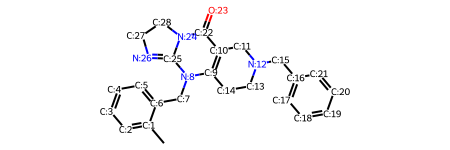

In [2]:
# draw the mol with index for experimental chemical shift alignment
mol = rdkit.Chem.MolFromSmiles('CC1=CC=CC=C1CN2C3=C(CN(CC3)CC4=CC=CC=C4)C(=O)N5C2=NCC5')
for atom in mol.GetAtoms():
    atom.SetAtomMapNum(atom.GetIdx())
mol

## DFT optimization of the 5 lowest energy conformers and select the lowest energy structure
As shown above, DFT calculation could be:
```
# opt freq B3LYP/6-31G(d) scrf=(solvent=Chloroform, smd)
```
After DFT optimization of the 5 lowest energy conformers, we select the lowest energy conformer as the final structure. 

## DFT GIAO calculation for shielding tensors
Using the final structure, we do the NMR-GIAO calculation for the molecule:
```
# B3LYP/6-31G(d) NMR=giao scrf=(solvent=Chloroform, smd)
```

## Dataset raw data organization

After the GIAO calculation, one NMR log file for each molecule should be generated. All the log files should be organized under the `raw/NMR_output` folder. After running the test process the dataset folder should look like this:
```bash
CUSTOM_DATASET
├── processed
│   ├── processed.pt
│   ├── split.pt
├── raw
│   ├── NMR_output
│   │   ├── TIC10a.log
│   │   ├── ...
```
Files in processed folder are generated by running the test process.